# test notebook to read data from h5

In [12]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd         # pandas tabular DataFrame for task/behavioral data
import matplotlib as mpl    # plot
import matplotlib.pyplot as plt
import re                   # regular expression
import time                 # time code execution
import pickle
import warnings
import h5py

import dg2df                # for DLSH dynamic group (behavioral data)
import neo                  # data structure for neural data
import quantities as pq
import signal_align         # in this package: align neural data according to task
import PyNeuroAna as pna    # in this package: analysis
import PyNeuroPlot as pnp   # in this package: plot
import misc_tools           # in this package: misc
import df_ana

import data_load_DLSH       # package specific for DLSH lab data


In [13]:
class DataNeural(dict):
    def __init__(self, data_dict):
        for (key, value) in data_dict.items():
            self[key] = value
#temp0=DataNeural(temp)

signal_info_detail = pd.read_pickle('/shared/homes/sguan/Coding_Projects/support_data/spike_wf_info_Dante.pkl')
def set_signal_id(signal_info):
    signal_info['signal_id'] = signal_info['date'].apply(lambda x: '{:0>6}'.format(x)).str.cat(
        [signal_info['channel_index'].apply(lambda x: '{:0>2}'.format(x)),
        signal_info['sort_code'].apply(lambda x: '{:0>1}'.format(x))],
        sep='_'
        )
    return signal_info
signal_info_detail = set_signal_id(signal_info_detail)



In [15]:
dir_data_save = '/shared/homes/sguan/Coding_Projects/support_data'
block_type = 'srv_mask'   # one of ['srv_mask', 'matchnot']
signal_type = 'spk'

hdf_file_path = '{}/all_data_dante_{}.hdf5'.format(dir_data_save, 'srv_mask')
# hdf_file_path = '{}/all_data_dante_{}.hdf5'.format(dir_data_save, 'matchnot')

with h5py.File(hdf_file_path, 'r') as hf:

    list_psth = []
    list_signal = []
    list_data_neuro = []

    for date in list(hf.keys()):
        print(date, 'reading_dg')

        data_df = pd.read_hdf(hdf_file_path, key='{}/trial_info'.format(date))
        # data_df = pd.read_json(hf[date]['trial_info_json'][()])
        data_df.sort_index(inplace=True)  #  critical!, json makes pandas DataFrame index out of order

        print(date, 'reading_neural')
        data_neural = dict([])
        data_neural['data'] = hf[date][signal_type]['data'][:]
        data_neural['ts'] = hf[date][signal_type]['ts'][:]
        data_neural['signal_id'] = hf[date][signal_type]['signal_id'][:]
        data_neural['trial_info'] = data_df
        list_data_neuro.append(data_neural)
        data_neural = signal_align.neuro_sort(data_df, grpby=['stim_familiarized','mask_opacity_int'], neuro=data_neural)
        psth = pna.GroupAve(data_neural)
        list_psth.append(psth)
        list_signal.append(data_neural['signal_id'])



115214 reading_dg
115214 reading_neural
124908 reading_dg
124908 reading_neural
125024 reading_dg
125024 reading_neural
130828 reading_dg
130828 reading_neural
132556 reading_dg
132556 reading_neural
132834 reading_dg
132834 reading_neural
133008 reading_dg
133008 reading_neural
133808 reading_dg
133808 reading_neural
135134 reading_dg
135134 reading_neural
135421 reading_dg
135421 reading_neural
140836 reading_dg
140836 reading_neural
143341 reading_dg
143341 reading_neural
144728 reading_dg
144728 reading_neural
150134 reading_dg
150134 reading_neural
150743 reading_dg
150743 reading_neural
150917 reading_dg
150917 reading_neural
151328 reading_dg
151328 reading_neural


In [7]:
if False:
    for data_neuro in list_data_neuro:

        data_neuro = data_neuro
        data_df = data_neuro['trial_info']

        grpby = 'stim_familiarized'
        df_group = df_ana.DfGroupby(data_df, groupby=grpby, tf_aggregate=False)
        for i_signal in range(len(data_neuro['signal_id'])):

            signal_name = str(data_neuro['signal_id'][i_signal])
            print(signal_name)

            date_cur, ch_cur, sortcode_cur = re.findall('(\d{6})_(\d*)_(\d*)', signal_name)[0]
            ch_cur = int(ch_cur)
            sortcode_cur = int(sortcode_cur)

            if int(ch_cur) >32:

                h_fig, h_axes = pnp.CreateSubplotFromGroupby(df_group['order'], tf_title=False)
                # plt.gcf().set_size_inches([10, 8])
                tf_legend = True
                for cdtn in df_group['idx']:
                    plt.axes(h_axes[cdtn])
                    pnp.PsthPlot(data_neuro['data'][:, :, i_signal], ts=data_neuro['ts'],
                                 cdtn=data_df['mask_opacity_int'], limit=df_group['idx'][cdtn], sk_std=0.010,
                                 tf_legend=tf_legend)
                    tf_legend = False
                    plt.title(cdtn, fontsize='small')
                plt.suptitle('{}'.format(signal_name))
                plt.show()
                plt.close('all')

In [8]:
list_tc_by_cdtn = []
list_signal_id = []
for data_neuro in list_data_neuro:

    data_df = data_neuro['trial_info']
    signal_id = data_neuro['signal_id'].astype('str')

    date_cur, ch_cur, sort_cur = zip(*[re.findall('(\d*)_(\d*)_(\d*)', signal_id_one)[0] for signal_id_one in signal_id])
    date_cur = np.array(date_cur)
    ch_cur = np.array(ch_cur, dtype='int')
    ch_sort = np.array(sort_cur, dtype='int')

    # data_neuro = signal_align.select_signal(data_neuro, indx=ch_cur>32)

    grpby = ['stim_familiarized', 'stim_sname']
    df_group = df_ana.DfGroupby(data_df, groupby=grpby, tf_aggregate=False, tf_linearize=True)

    num_signal = data_neuro['data'].shape[2]
    tc_by_cdtn = np.zeros([6, 10, num_signal])

    for i_signal in range(data_neuro['data'].shape[2]):
        try:
            signal_name = data_neuro['signal_id'][i_signal]
            
            if False:
                h_fig, h_axes = pnp.CreateSubplotFromGroupby(df_group['order'], tf_title=False, figsize=[10,8])
                tf_legend = True
                for cdtn in df_group['idx']:
                    plt.axes(h_axes[cdtn])
                    pnp.PsthPlot(data_neuro['data'][:, :, i_signal], ts=data_neuro['ts'],
                                 cdtn=data_df['mask_opacity_int'], limit=df_group['idx'][cdtn], sk_std=0.010,
                                 tf_legend=tf_legend)
                    tf_legend = False
                    plt.title(cdtn, fontsize='small')
                plt.suptitle('{}'.format(signal_name))
                plt.show()
                plt.close('all')
            t_window=[0.050, 0.250]
            x_fam, fr_mean_fam_00 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==0 ) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=t_window)
            x_fam, fr_mean_fam_50 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==50) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=t_window)
            x_fam, fr_mean_fam_70 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==70) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=t_window)
            x_nov, fr_mean_nov_00 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==0 ) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=t_window)
            x_nov, fr_mean_nov_50 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==50) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=t_window)
            x_nov, fr_mean_nov_70 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==70) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=t_window)
            #x, fr_fam_std = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], ts=data_neuro['ts'], t_window=[0.050, 0.250], stat_trials='std')

            tc_by_cdtn[0 , :, i_signal] = fr_mean_fam_00
            tc_by_cdtn[1 , :, i_signal] = fr_mean_fam_50
            tc_by_cdtn[2 , :, i_signal] = fr_mean_fam_70
            tc_by_cdtn[3 , :, i_signal] = fr_mean_nov_00
            tc_by_cdtn[4 , :, i_signal] = fr_mean_nov_50
            tc_by_cdtn[5 , :, i_signal] = fr_mean_nov_70
            
            if False:
                r_pearson_fam_50 = sp.stats.pearsonr(fr_mean_fam_00, fr_mean_fam_50)[0]
                r_pearson_fam_70 = sp.stats.pearsonr(fr_mean_fam_00, fr_mean_fam_70)[0]
                r_pearson_nov_50 = sp.stats.pearsonr(fr_mean_nov_00, fr_mean_nov_50)[0]
                r_pearson_nov_70 = sp.stats.pearsonr(fr_mean_nov_00, fr_mean_nov_70)[0]

                r_spearman_fam_50 = sp.stats.spearmanr(fr_mean_fam_00, fr_mean_fam_50)[0]
                r_spearman_fam_70 = sp.stats.spearmanr(fr_mean_fam_00, fr_mean_fam_70)[0]
                r_spearman_nov_50 = sp.stats.spearmanr(fr_mean_nov_00, fr_mean_nov_50)[0]
                r_spearman_nov_70 = sp.stats.spearmanr(fr_mean_nov_00, fr_mean_nov_70)[0]

                h_fig, h_axes = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(10, 5))
                plt.axes(h_axes[0])
                plt.plot(fr_mean_fam_00, fr_mean_fam_50, 'o')
                plt.plot(fr_mean_nov_00, fr_mean_nov_50, 'o')
                plt.legend(['r_fam={:.2f}, {:.2f}'.format(r_pearson_fam_50, r_spearman_fam_50), 'r_nov={:.2f}, {:.2f}'.format(r_pearson_nov_50, r_spearman_nov_50)])
                plt.title('50% noise')
                plt.axes(h_axes[1])
                plt.plot(fr_mean_fam_00, fr_mean_fam_70, 'o')
                plt.plot(fr_mean_nov_00, fr_mean_nov_70, 'o')
                plt.legend(['r_fam={:.2f}, {:.2f}'.format(r_pearson_fam_70, r_spearman_fam_70), 'r_nov={:.2f}, {:.2f}'.format(r_pearson_nov_70, r_spearman_nov_70)])
                plt.title('70% noise')
                plt.axis('equal')
                plt.suptitle(signal_name)
                plt.show()
                plt.close()
        except:
            warnings.warn('signal {} can not be processed'.format(signal_name))
    list_tc_by_cdtn.append(tc_by_cdtn)
    list_signal_id.append(signal_id)
     

In [7]:
if False:
    with open('/shared/homes/sguan/Coding_Projects/support_data/dante_all_tc_by_cdtn.pkl', 'wb') as f:
        pickle.dump(dict_tc_by_cdtn, f)

In [10]:
with open('/shared/homes/sguan/Coding_Projects/support_data/dante_all_tc_by_cdtn.pkl', 'rb') as f:
    dict_tc_by_cdtn = pickle.load(f)

In [11]:
sigal_id_all = np.concatenate(list_signal_id)
len(sigal_id_all)

ValueError: need at least one array to concatenate

In [9]:
list_tc_by_cdtn = []
list_signal_id = []

tc_by_cdtn_all = np.concatenate(list_tc_by_cdtn, axis=2)
signal_id_all = np.concatenate(list_signal_id)
signal_info_tc = signal_info_detail[(signal_info_detail['sort_code']>0) & signal_info_detail['signal_id'].isin(signal_id_all)]
signal_info_tc.reset_index(inplace=True)

num_signal = tc_by_cdtn_all.shape[2]

cdtn_label = [('fam', 0), ('fam', 50), ('fam', 70), ('nov', 0), ('nov', 50), ('nov', 70)]
pearsonr_all = np.zeros(shape=(4, num_signal))
spearmanr_all = np.zeros(shape=(4, num_signal))
index_corr_using_cdtn = {0: (0, 1), 1: (0, 2), 2: (3, 4), 3: (3, 5)}


for i_signal in range(num_signal):
    for index_corr, (index0_cdtn, index1_cdtn) in index_corr_using_cdtn.items():
        pearsonr_all[index_corr, i_signal] = sp.stats.pearsonr(tc_by_cdtn_all[index0_cdtn, :, i_signal], 
                                                               tc_by_cdtn_all[index1_cdtn, :, i_signal])[0]
        spearmanr_all[index_corr, i_signal] = sp.stats.spearmanr(tc_by_cdtn_all[index0_cdtn, :, i_signal], 
                                                                 tc_by_cdtn_all[index1_cdtn, :, i_signal])[0]

tc_std = np.std(tc_by_cdtn_all, axis=1)

yn_keep_signal = (signal_info_tc['area']!='V4')

print(np.sum(yn_keep_signal))

yn_keep_signal = yn_keep_signal \
                & (tc_std[0]>2) & (tc_std[3]>2) \
                & (tc_std[0]/tc_std[3]<1.5) & (tc_std[3]/tc_std[0]<1.5)

print(np.sum(yn_keep_signal))        

#def PlotCodingRobustness()
h_fig, h_axes = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(8, 8))
plt.axes(h_axes[0, 0])
plt.plot(pearsonr_all[0, yn_keep_signal], pearsonr_all[2, yn_keep_signal], 'o', alpha=0.5)
plt.plot([0,1], [0,1])

plt.axes(h_axes[0, 1])
plt.plot(pearsonr_all[1, yn_keep_signal], pearsonr_all[3, yn_keep_signal], 'o', alpha=0.5)
plt.plot([0,1], [0,1])

plt.axes(h_axes[1, 0])
plt.plot(spearmanr_all[0, yn_keep_signal], pearsonr_all[2, yn_keep_signal], 'o', alpha=0.5)
plt.plot([0,1], [0,1])

plt.axes(h_axes[1, 1])
plt.plot(spearmanr_all[1, yn_keep_signal], pearsonr_all[3, yn_keep_signal], 'o', alpha=0.5)
plt.plot([0,1], [0,1])

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()
plt.close('all')



h_fig, h_axes = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(8, 8))
plt.axes(h_axes[0, 0])
plt.hist(pearsonr_all[0, yn_keep_signal]-pearsonr_all[2, yn_keep_signal])

plt.axes(h_axes[0, 1])
plt.hist(pearsonr_all[1, yn_keep_signal]-pearsonr_all[3, yn_keep_signal])

plt.axes(h_axes[1, 0])
plt.hist(spearmanr_all[0, yn_keep_signal]-pearsonr_all[2, yn_keep_signal])

plt.axes(h_axes[1, 1])
plt.hist(spearmanr_all[1, yn_keep_signal]-pearsonr_all[3, yn_keep_signal])

plt.show()
plt.close('all')

ValueError: need at least one array to concatenate

In [76]:
list_tc_by_cdtn = []
list_tc_std_by_cdtn = []
list_signal_id = []
for data_neuro in list_data_neuro:

    data_df = data_neuro['trial_info']
    signal_id = data_neuro['signal_id'].astype('str')

    date_cur, ch_cur, sort_cur = zip(*[re.findall('(\d*)_(\d*)_(\d*)', signal_id_one)[0] for signal_id_one in signal_id])
    date_cur = np.array(date_cur)
    ch_cur = np.array(ch_cur, dtype='int')
    ch_sort = np.array(sort_cur, dtype='int')

    # data_neuro = signal_align.select_signal(data_neuro, indx=ch_cur>32)

    grpby = ['stim_familiarized', 'stim_sname']
    df_group = df_ana.DfGroupby(data_df, groupby=grpby, tf_aggregate=False, tf_linearize=True)

    num_signal = data_neuro['data'].shape[2]
    tc_by_cdtn = np.zeros([6, 10, num_signal])
    tc_std_by_cdtn = np.zeros([6, 10, num_signal])

    for i_signal in range(data_neuro['data'].shape[2]):
        signal_name = data_neuro['signal_id'][i_signal]

        t_window=[0.050, 0.350]
        x_fam, fr_mean_fam_00 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==0 ) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=t_window)
        x_fam, fr_mean_fam_50 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==50) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=t_window)
        x_fam, fr_mean_fam_70 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==70) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=t_window)
        x_nov, fr_mean_nov_00 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==0 ) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=t_window)
        x_nov, fr_mean_nov_50 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==50) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=t_window)
        x_nov, fr_mean_nov_70 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==70) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=t_window)


        x_fam, fr_std_fam_00 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==0 ) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=t_window, stat_trials='std')
        x_fam, fr_std_fam_50 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==50) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=t_window, stat_trials='std')
        x_fam, fr_std_fam_70 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==70) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=t_window, stat_trials='std')
        x_nov, fr_std_nov_00 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==0 ) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=t_window, stat_trials='std')
        x_nov, fr_std_nov_50 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==50) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=t_window, stat_trials='std')
        x_nov, fr_std_nov_70 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==70) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=t_window, stat_trials='std')

        tc_by_cdtn[0 , :, i_signal] = fr_mean_fam_00
        tc_by_cdtn[1 , :, i_signal] = fr_mean_fam_50
        tc_by_cdtn[2 , :, i_signal] = fr_mean_fam_70
        tc_by_cdtn[3 , :, i_signal] = fr_mean_nov_00
        tc_by_cdtn[4 , :, i_signal] = fr_mean_nov_50
        tc_by_cdtn[5 , :, i_signal] = fr_mean_nov_70

        tc_std_by_cdtn[0 , :, i_signal] = fr_std_fam_00
        tc_std_by_cdtn[1 , :, i_signal] = fr_std_fam_50
        tc_std_by_cdtn[2 , :, i_signal] = fr_std_fam_70
        tc_std_by_cdtn[3 , :, i_signal] = fr_std_nov_00
        tc_std_by_cdtn[4 , :, i_signal] = fr_std_nov_50
        tc_std_by_cdtn[5 , :, i_signal] = fr_std_nov_70


    list_tc_by_cdtn.append(tc_by_cdtn)
    list_tc_std_by_cdtn.append(tc_std_by_cdtn)
    list_signal_id.append(signal_id)

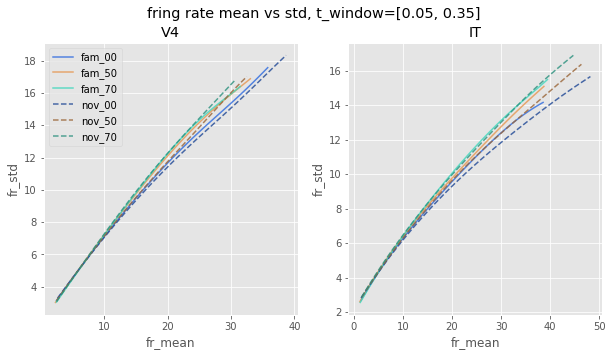

In [77]:
from sklearn.kernel_ridge import KernelRidge
import statsmodels.nonparametric.kernel_regression as kernel_regression

tc_by_cdtn_all = np.concatenate(list_tc_by_cdtn, axis=2)
tc_std_by_cdtn_all = np.concatenate(list_tc_std_by_cdtn, axis=2)
signal_id_all = np.concatenate(list_signal_id)
signal_info_tc = signal_info_detail[(signal_info_detail['sort_code']>0) & signal_info_detail['signal_id'].isin(signal_id_all)]
signal_info_tc.reset_index(inplace=True)

def plot_kr(x,y, color='k', linestyle='-'):
    range_x = np.percentile(x, [5, 95])
    kr = kernel_regression.KernelReg(y, x, ['c'], bw=[np.diff(range_x) / 5])
    xx = np.linspace(range_x[0], range_x[1], 100)
    plt.plot(xx, kr.fit(xx)[0], '-', color=color, linestyle=linestyle)

    
colors = np.vstack([pnp.gen_distinct_colors(3, luminance=0.9), pnp.gen_distinct_colors(3, luminance=0.6)])
linestyles = ['-', '-', '-', '--', '--', '--']
       

h_fig, h_axes =  plt.subplots(1,2, squeeze=False, figsize=(10,5))
plt.axes(h_axes[0, 0])
yn_keep_signal = (signal_info_tc['area']=='V4')
for i in range(6):
    plot_kr(tc_by_cdtn_all[i, :, yn_keep_signal].ravel(), tc_std_by_cdtn_all[i, :, yn_keep_signal].ravel(),
            color=colors[i], linestyle=linestyles[i])
plt.xlabel('fr_mean')
plt.ylabel('fr_std')
plt.title('V4')
plt.legend(['fam_00', 'fam_50', 'fam_70', 'nov_00', 'nov_50', 'nov_70'])
''
plt.axes(h_axes[0, 1])
yn_keep_signal = (signal_info_tc['area']!='V4')
for i in range(6):
    plot_kr(tc_by_cdtn_all[i, :, yn_keep_signal].ravel(), tc_std_by_cdtn_all[i, :, yn_keep_signal].ravel(),
            color=colors[i], linestyle=linestyles[i])
plt.xlabel('fr_mean')
plt.ylabel('fr_std')
plt.title('IT')
plt.suptitle('fring rate mean vs std, t_window={}'.format(t_window), fontsize='x-large')
plt.savefig('../temp_figs/fring_rate_mean_vs_std, t_window={}.png'.format(t_window))
plt.show()
plt.close('all')


In [71]:
pwd

'/shared/homes/sguan/Coding_Projects/PyNeuroSG/script'

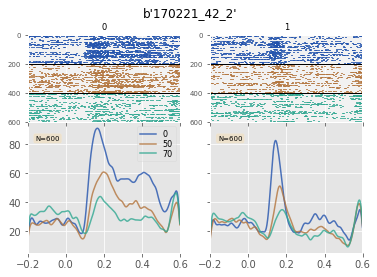

(1200, 813, 23) 1200


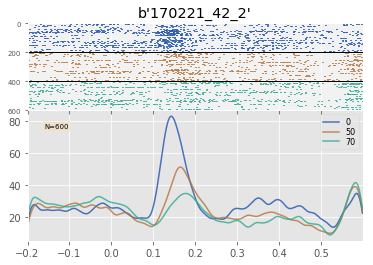

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199],
           dtype='int64', length=1200)

In [25]:
data_neuro = data_neural_srv_mask
data_df = data_neural_srv_mask['trial_info']

# data_neural = signal_align.neuro_sort(data_df, grpby=['mask_opacity_int'], neuro=data_neuro)、

# psth = pna.GroupAve(data_neural)
# psth_smooth = pna.SmoothTrace(psth, sk_std=0.010, ts=data_neuro['ts'], axis=1)
# print(psth_smooth.shape)

# psth_plot = np.mean(psth_smooth[:, :, 21:22], axis=2)

# plt.plot(psth_plot.transpose())
# plt.show()
# plt.close()


grpby = 'stim_familiarized'
df_group = df_ana.DfGroupby(data_df, groupby=grpby, tf_aggregate=False)

i_signal = -2

signal_name = data_neuro['signal_id'][i_signal]
h_fig, h_axes = pnp.CreateSubplotFromGroupby(df_group['order'], tf_title=False)

tf_legend = True
for cdtn in df_group['idx']:
    plt.axes(h_axes[cdtn])
    pnp.PsthPlot(data_neuro['data'][:, :, i_signal], ts=data_neuro['ts'],
                 cdtn=data_df['mask_opacity_int'], limit=df_group['idx'][cdtn], sk_std=0.010,
                 tf_legend=tf_legend)
    tf_legend = False
    plt.title(cdtn, fontsize='small')
plt.suptitle('{}'.format(signal_name))
plt.show()
plt.close('all')

print(data_neuro['data'].shape, len(data_df))
pnp.PsthPlot(data_neuro['data'][:,:, i_signal], ts=data_neuro['ts'],
                     cdtn=data_df['mask_opacity_int'], limit=data_df['stim_familiarized']==1, sk_std=0.010,
                     tf_legend=True)
plt.title(data_neuro['signal_id'][i_signal])
plt.show()
plt.close()

data_df.index

(6, 813, 505) (6, 813) (505, 10)


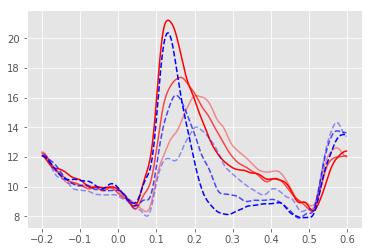

In [6]:
ts_srv_mask = data_neural_srv_mask['ts']
# ts_matchnot = data_neural_matchnot['ts']
signal_srv_mask = np.concatenate(list_signal_srv_mask).astype('str')
# signal_matchnot = np.concatenate(list_signal_matchnot).astype('str')
signal_all = np.unique(np.concatenate(list_signal_srv_mask + list_signal_matchnot).astype('str'))

psth_all_srv_mask = np.concatenate(list_psth_srv_mask, axis=2)
# psth_all_matchnot = np.concatenate(list_psth_matchnot, axis=2)
signal_full_srv_mask = pd.DataFrame({'signal_id': signal_srv_mask}).merge(signal_info_detail, how='inner', on=['signal_id'], copy=False)
# signal_full_matchnot = pd.DataFrame({'signal_id': signal_matchnot}).merge(signal_info_detail, how='inner', on=['signal_id'], copy=False)



psth_all_smooth = pna.SmoothTrace(psth_all_srv_mask, sk_std=0.010, ts=ts_srv_mask, axis=1)
psth_plot = np.mean(psth_all_smooth[:, :, signal_full_srv_mask['area']=='TEm'], axis=2)

print(psth_all_srv_mask.shape, psth_plot.shape, signal_full_srv_mask.shape)

list_color = ['r','r','r','b','b','b']
list_ls = ['-', '-', '-', '--', '--', '--']
list_alpha = [1.0, 0.7, 0.4, 1.0, 0.7, 0.4]

for i in range(6):
    plt.plot(ts_srv_mask, psth_plot[i, :], color=list_color[i], ls = list_ls[i], alpha = list_alpha[i])
plt.show()
plt.close('all')

if False:
    psth_all_smooth = pna.SmoothTrace(psth_all_srv_mask, sk_std=0.020, ts=ts_srv_mask, axis=1)
    psth_plot = psth_all_smooth[2][:, (signal_full_srv_mask['wf_type']=='BS') * (signal_full_srv_mask['area']=='TEd')]
    list_color = pnp.gen_distinct_colors(psth_plot.shape[1])
    for i in range(psth_plot.shape[1]):
        plt.plot(ts_srv_mask, psth_plot[:,i], color=list_color[i])
    plt.title('TEm_BS_by_cells')
    #plt.savefig('./temp_figs/TEm_BS_by_cells')
    plt.show()
    plt.close('all')

In [5]:
print(signal_info_detail)

        date   signal_name  channel_index  sort_code  num_spk wf_type  \
0     161015   Chan1 Code1              1          1    33798           
1     161015   Chan1 Code2              1          2     5871           
2     161015   Chan2 Code2              2          2    42438           
3     161015   Chan3 Code0              3          0     5552           
4     161015   Chan4 Code0              4          0     6540           
5     161015   Chan5 Code1              5          1    17848           
6     161015   Chan6 Code0              6          0        1           
7     161015   Chan6 Code1              6          1     8471           
8     161015   Chan7 Code0              7          0     8298           
9     161015   Chan8 Code0              8          0        4           
10    161015   Chan8 Code1              8          1    11336           
11    161015   Chan9 Code0              9          0     7307           
12    161015   Chan9 Code1              9          

In [5]:
date = '161023'
data_df = pd.read_json(hf[date]['trial_info_json'][()])
# data_df = pd.read_hdf(hdf_file_path, '{}/trial_info'.format(date))
data_neural = dict([])
data_neural['data'] = hf[date][signal_type]['data'][:]
data_neural['ts'] = hf[date][signal_type]['ts'][:]
data_neural['signal_id'] = hf[date][signal_type]['signal_id'][:]
data_neural['trial_info'] = data_df

list_date = hf.keys()
list_psth = []
list_signal = []
for date in list_date:
    print(date, 'reading_dg')
    data_df = pd.read_json(hf[date]['trial_info_json'][()])
    # data_df = pd.read_hdf(hdf_file_path, '{}/trial_info'.format(date))
    print(date, 'reading_neural')
    data_neural = dict([])
    data_neural['data'] = hf[date][signal_type]['data'][:]
    data_neural['ts'] = hf[date][signal_type]['ts'][:]
    data_neural['signal_id'] = hf[date][signal_type]['signal_id'][:]
    data_neural['trial_info'] = data_df
    data_neural = signal_align.neuro_sort(data_df, grpby=['stim_familiarized','mask_opacity_int'], neuro=data_neural)
    psth = pna.GroupAve(data_neural)
    list_psth.append(psth)
    list_signal.append(data_neural['signal_id'])

ts = data_neural['ts']
signal_all = np.concatenate(list_signal)
psth_all = np.concatenate(list_psth, axis=2)
signal_full = pd.DataFrame({'signal_id': signal_all}).merge(signal_info_detail, how='inner', on=['signal_id'], copy=False)

psth_all_smooth = pna.SmoothTrace(psth_all, sk_std=0.005, ts=ts, axis=1)
psth_plot = np.mean(psth_all_smooth[:, :, (signal_full['wf_type']=='BS') * (signal_full['area']=='TEm')], axis=2)

list_color = ['r','r','r','b','b','b']
list_ls = ['-', '-', '-', '--', '--', '--']
list_alpha = [1.0, 0.7, 0.4, 1.0, 0.7, 0.4]

for i in range(6):
    plt.plot(ts, psth_plot[i, :], color=list_color[i], ls = list_ls[i], alpha = list_alpha[i])

psth_all_smooth = pna.SmoothTrace(psth_all, sk_std=0.020, ts=ts, axis=1)
psth_plot = psth_all_smooth[2][:, (signal_full['wf_type']=='BS') * (signal_full['area']=='TEm')]
list_color = pnp.gen_distinct_colors(psth_plot.shape[1])
for i in range(psth_plot.shape[1]):
    plt.plot(ts, psth_plot[:,i], color=list_color[i])
plt.title('TEm_BS_by_cells')
#plt.savefig('./temp_figs/TEm_BS_by_cells')
plt.show()
plt.close('all')



NameError: name 'hf' is not defined

/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


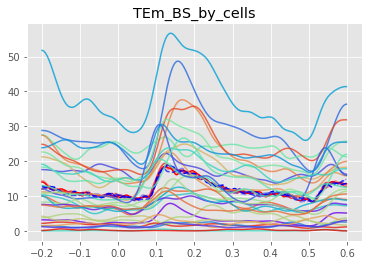

In [35]:
ts = data_neural['ts']
signal_all = np.concatenate(list_signal)
psth_all = np.concatenate(list_psth, axis=2)
signal_full = pd.DataFrame({'signal_id': signal_all.astype('str')}).merge(signal_info_detail, how='inner', on=['signal_id'], copy=False)

psth_all_smooth = pna.SmoothTrace(psth_all, sk_std=0.005, ts=ts, axis=1)
psth_plot = np.mean(psth_all_smooth[:, :, (signal_full['wf_type']=='BS') * (signal_full['area']=='TEm')], axis=2)

list_color = ['r','r','r','b','b','b']
list_ls = ['-', '-', '-', '--', '--', '--']
list_alpha = [1.0, 0.7, 0.4, 1.0, 0.7, 0.4]

for i in range(6):
    plt.plot(ts, psth_plot[i, :], color=list_color[i], ls = list_ls[i], alpha = list_alpha[i])

psth_all_smooth = pna.SmoothTrace(psth_all, sk_std=0.020, ts=ts, axis=1)
psth_plot = psth_all_smooth[2][:, (signal_full['wf_type']=='BS') * (signal_full['area']=='TEm')]
list_color = pnp.gen_distinct_colors(psth_plot.shape[1])
for i in range(psth_plot.shape[1]):
    plt.plot(ts, psth_plot[:,i], color=list_color[i])
plt.title('TEm_BS_by_cells')
#plt.savefig('./temp_figs/TEm_BS_by_cells')
plt.show()
plt.close('all')

In [13]:
signal_full_srv_mask

,signal_id,date,signal_name,channel_index,sort_code,num_spk,wf_type,wf,area,depth
0,161015_01_1,161015,Chan1 Code1,1,1,33798,,"[-6.39568156657333e-07, -7.072243874972628e-07...",V4,NaN
1,161015_01_2,161015,Chan1 Code2,1,2,5871,,"[-9.904590569931315e-07, -9.577245236869203e-0...",V4,NaN
2,161015_02_2,161015,Chan2 Code2,2,2,42438,,"[-8.543582339370914e-07, -9.284999578085262e-0...",V4,NaN
3,161015_05_1,161015,Chan5 Code1,5,1,17848,,"[-3.027197863048059e-06, -3.1636709536542185e-...",V4,NaN
4,161015_06_1,161015,Chan6 Code1,6,1,8471,,"[6.326794732558483e-07, 9.595951269147918e-07,...",V4,NaN
5,161015_08_1,161015,Chan8 Code1,8,1,11336,,"[-1.4659386806670227e-06, -1.6407351495217881e...",V4,NaN
6,161015_09_1,161015,Chan9 Code1,9,1,5433,,"[-4.260783725840156e-07, -3.5916562524107576e-...",V4,NaN
7,161015_11_1,161015,Chan11 Code1,11,1,13193,,"[-6.495460525002272e-07, -6.061660542400205e-0...",V4,NaN
8,161015_11_2,161015,Chan11 Code2,11,2,6659,,"[-9.535533536109142e-07, -1.057936174220231e-0...",V4,NaN
9,161015_12_1,161015,Chan12 Code1,12,1,17453,,"[-1.230189809575677e-06, -1.430703036930936e-0...",V4,NaN


In [21]:
data_neural_srv_mask

{'data': array([[[   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         ...,
         [   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ]],
 
        [[   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.        , ...,
             0.        ,    0.        ,    0.        ],
         [   0.        ,    0.        ,    0.  

In [68]:
import importlib; importlib.reload(pna)

<module 'PyNeuroAna' from '/shared/homes/sguan/Coding_Projects/PyNeuroSG/PyNeuroAna.py'>

In [20]:
data_neuro['grpby']

['stim_familiarized', 'mask_opacity_int']

In [38]:
re.findall('(\d{6})_(\d*)_(\d*)', str(signal_name))[0]

('170221', '42', '2')